In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter
from fuzzywuzzy import process, fuzz
import pickle
import re

/opt/anaconda3/envs/iron/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


https://www.kaggle.com/datasets/the-guardian/extinct-languages
https://www.kaggle.com/datasets/narmelan/100-most-spoken-languages-around-the-world

https://es.wikipedia.org/wiki/Lenguas_de_los_Estados_Unidos

In [2]:
# cargamos el csv 
df= pd.read_csv("data.csv")
df.head(2)

,ID,Name in English,Name in French,Name in Spanish,Countries,Country codes alpha 3,ISO639-3 codes,Degree of endangerment,Alternate names,Name in the language,Number of speakers,Sources,Latitude,Longitude,Description of the location
0,1022,South Italian,italien du sud,napolitano-calabrés,Italy,ITA,nap,Vulnerable,Neapolitan; Neapolitan-Calabrese; неаполитанск...,NaN,7500000.0,NaN,40.9798,15.2490,"Campania, Lucania (Basilicata), Abruzzi (Abruz..."
1,1023,Sicilian,sicilien,siciliano,Italy,ITA,scn,Vulnerable,NaN,NaN,5000000.0,NaN,37.4399,14.5019,"Sicily (Sicilia), southern and central Calabri..."


In [3]:
df.shape

(2722, 15)

In [4]:
#eliminar id, mantener codes alpha 3 
df_new=df.drop(labels=['ID','Name in French', 'Name in Spanish','ISO639-3 codes','Alternate names','Name in the language','Sources','Description of the location'], axis=1)

In [5]:
df_new.head(2)

,Name in English,Countries,Country codes alpha 3,Degree of endangerment,Number of speakers,Latitude,Longitude
0,South Italian,Italy,ITA,Vulnerable,7500000.0,40.9798,15.2490
1,Sicilian,Italy,ITA,Vulnerable,5000000.0,37.4399,14.5019


In [6]:
df_new.columns

Index(['Name in English', 'Countries', 'Country codes alpha 3',
       'Degree of endangerment', 'Number of speakers', 'Latitude',
       'Longitude'],
      dtype='object')

In [7]:
df_new.columns = df_new.columns.str.lower()
df_new.head(1)

,name in english,countries,country codes alpha 3,degree of endangerment,number of speakers,latitude,longitude
0,South Italian,Italy,ITA,Vulnerable,7500000.0,40.9798,15.249


In [8]:
df_new = df_new.rename(columns={'name in english':'name',
                                   'ountry codes alpha':'code_alpha3',
                               'degree of endangerment':'endangerment',
                               'number of speakers': 'speakers'})
df_new.head(1)

,name,countries,country codes alpha 3,endangerment,speakers,latitude,longitude
0,South Italian,Italy,ITA,Vulnerable,7500000.0,40.9798,15.249


In [9]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2722 entries, 0 to 2721
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   2722 non-null   object 
 1   countries              2721 non-null   object 
 2   country codes alpha 3  2721 non-null   object 
 3   endangerment           2722 non-null   object 
 4   speakers               2539 non-null   float64
 5   latitude               2719 non-null   float64
 6   longitude              2719 non-null   float64
dtypes: float64(3), object(4)
memory usage: 149.0+ KB


In [10]:
df_new.duplicated().sum()

0

In [11]:
#visualizamos los nulos
#para decidir que nombre utilizamos en este caso utilizaremos el nombre de la lengua en ignles 
df_new.isnull().sum()

name                       0
countries                  1
country codes alpha 3      1
endangerment               0
speakers                 183
latitude                   3
longitude                  3
dtype: int64

In [12]:
df_new['endangerment'].value_counts()

Definitely endangered    680
Vulnerable               628
Critically endangered    607
Severely endangered      554
Extinct                  253
Name: endangerment, dtype: int64

In [13]:
df_new[df_new['speakers'].isnull()]

,name,countries,country codes alpha 3,endangerment,speakers,latitude,longitude
2539,A'tong,India,IND,Severely endangered,NaN,25.2844,91.1755
2540,Aché,Paraguay,PRY,Definitely endangered,NaN,-25.6613,-55.6787
2541,Akie,United Republic of Tanzania,TZA,Critically endangered,NaN,-4.7735,37.3315
2542,Akuriyo,Suriname,SUR,Critically endangered,NaN,2.8442,-55.7556
2543,Alemannic,"Germany, Austria, France, Italy, Liechtenstein...","DEU, AUT, FRA, ITA, LIE, CHE",Vulnerable,NaN,47.2792,7.6904
...,...,...,...,...,...,...,...
2717,Yonaguni,Japan,JPN,Severely endangered,NaN,24.4580,122.9802
2718,Yucuna,Colombia,COL,Definitely endangered,NaN,-1.2633,-70.6640
2719,Yurutí (Colombia),Colombia,COL,Definitely endangered,NaN,1.1370,-70.2136
2720,Zangskari,"India, Pakistan","IND, PAK",Definitely endangered,NaN,34.0833,76.8500


In [14]:
df_new[df_new['countries'].isnull()]

,name,countries,country codes alpha 3,endangerment,speakers,latitude,longitude
405,Boro,NaN,NaN,Definitely endangered,19878.0,10.3581,35.0024


In [18]:
df_new['speakers'] = df_new['speakers'].fillna(0)

In [19]:
df_new.isnull().sum()

name                     0
countries                1
country codes alpha 3    1
endangerment             0
speakers                 0
latitude                 3
longitude                3
dtype: int64

###

In [20]:
df_new = df_new.dropna()
df_new.isnull().sum()

name                     0
countries                0
country codes alpha 3    0
endangerment             0
speakers                 0
latitude                 0
longitude                0
dtype: int64

In [21]:
df_new.shape

(2718, 7)

In [22]:
#df_new.to_csv('df_new.csv', sep=',', index=True)

In [23]:
df_new['endangerment'].unique()

array(['Vulnerable', 'Definitely endangered', 'Severely endangered',
       'Critically endangered', 'Extinct'], dtype=object)

In [24]:
df_new['endangerment'].value_counts()

Definitely endangered    679
Vulnerable               627
Critically endangered    606
Severely endangered      554
Extinct                  252
Name: endangerment, dtype: int64

In [25]:
# Paises en los cuales hay mayor presencia de lenguas en peligro 
counts= df_new["countries"].value_counts()
print(counts)

United States of America                                                                                                                                                                                                                                                                                             216
Brazil                                                                                                                                                                                                                                                                                                               186
India                                                                                                                                                                                                                                                                                                                163
Indonesia                                                    

In [26]:
counts_sort = counts.sort_values(ascending=False)

counts_sort.head(10)

United States of America    216
Brazil                      186
India                       163
Indonesia                   149
Mexico                      143
China                       122
Russian Federation          119
Australia                   108
Papua New Guinea             98
Canada                       82
Name: countries, dtype: int64

In [ ]:
#fig = px.pie(df_new, values='speakers', names='countries', title='number')
#fig.show()

In [ ]:
df_peru= df_new[df_new['countries'].str.contains('Peru')]

In [ ]:
fig = px.pie(df_peru, values='speakers', names='endangerment', title='endangerment_peru')
fig.show()

### BRAZIL 

In [40]:
df_brazil = df_new[df_new['countries'].str.contains('Brazil')]
df_brazil.head(4)


,name,countries,country codes alpha 3,endangerment,speakers,latitude,longitude
298,Ticuna,"Brazil, Colombia, Peru","BRA, COL, PER",Definitely endangered,35000.0,-4.3464,-70.0048
392,Kaiowá Guarani,Brazil,BRA,Vulnerable,20000.0,-21.5812,-55.0759
409,Terena,Brazil,BRA,Severely endangered,19000.0,-20.2841,-55.4638
412,Kaingang,Brazil,BRA,Definitely endangered,18500.0,-28.1495,-52.4707


In [41]:
df_brazil['countries'].unique()

array(['Brazil, Colombia, Peru', 'Brazil',
       'Brazil, Colombia, Venezuela (Bolivarian Republic of)',
       'Brazil, Paraguay', 'Brazil, Suriname'], dtype=object)

In [42]:
df_brazil.shape

(190, 7)

### USA

In [36]:
df_usa=df_new[df_new['countries'].str.contains('United States of America')]
df_usa.head(3)

,name,countries,country codes alpha 3,endangerment,speakers,latitude,longitude
156,Navajo,United States of America,USA,Vulnerable,120000.0,35.8044,-108.4750
359,Sioux,United States of America,USA,Vulnerable,25000.0,43.0588,-102.5244
443,O'odham (Akimel),United States of America,USA,Definitely endangered,15000.0,33.0590,-112.0479


In [44]:
df_usa=df_usa.drop(labels=['countries','country codes alpha 3','speakers'], axis=1)

KeyError: "['countries', 'country codes alpha 3', 'speakers'] not found in axis"

In [45]:
df_usa.head(2)

,name,endangerment,latitude,longitude
156,Navajo,Vulnerable,35.8044,-108.4750
359,Sioux,Vulnerable,43.0588,-102.5244


In [46]:
df_usa.shape

(227, 4)

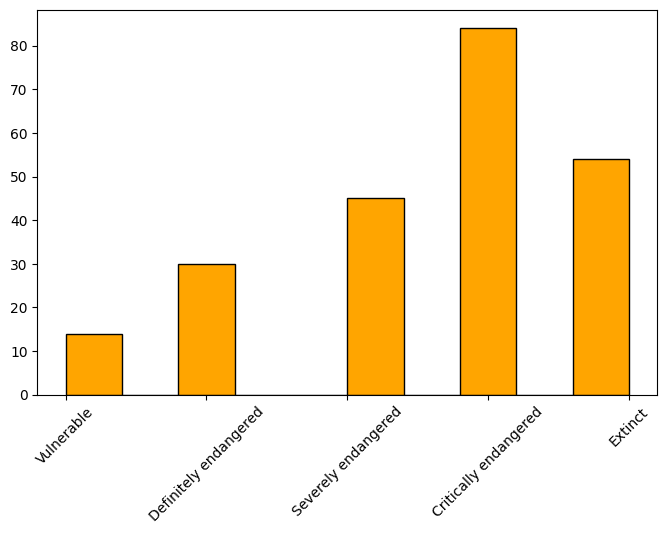

In [56]:
plt.figure(figsize = (8,5)) # para establecer el tamaño de la figura. Este tamaño solo se aplicará a esta figura 

plt.hist(df_usa["endangerment"], edgecolor = "black", 
                        facecolor = "orange", 
                        bins = 10)
plt.xticks(rotation=45);

In [57]:
#df_usa.to_csv('df_usa.csv', sep=',', index=True)

### MEXICO

In [ ]:
df_mex=df_new[df_new['countries'].str.contains('Mexico')]
df_mex.head(3)

In [ ]:
fig = px.pie(df_mex, values='speakers', names='', title='endangerment MX')
fig.show()

### CHINA

In [ ]:
df_india=df_new[df_new['countries'].str.contains('India')]
df_india.head(3)

In [ ]:
fig = px.pie(df_india, values='speakers', names='endangerment', title='endangerment INDIA')
fig.show()

## most spoken 

In [59]:
df_top= pd.read_csv("top_languages.csv")
df_top.head(5)

,Language,Total Speakers,Native Speakers,Origin
0,English,1132366680,379007140.0,Indo-European
1,Mandarin Chinese,1116596640,917868640.0,Sino-Tibetan
2,Hindi,615475540,341208640.0,Indo-European
3,Spanish,534335730,460093030.0,Indo-European
4,French,279821930,77177210.0,Indo-European


In [ ]:
df_top.isnull().sum()

In [ ]:
df_top.shape

In [ ]:
counts= df_top["Total Speakers"].value_counts()
df_sort= counts.sort_values(ascending=False)
df_sort

In [ ]:
fig = px.pie(df_top, values='Total Speakers', names='Origin', title="Percentage Breakdown of Language Groups")
fig.show()

https://www.census.gov/dataviz/visualizations/045/
https://www.census.gov/dataviz/visualizations/045/508.php